# Identifying Phase Transitions

In this notebook, we will use numerous methods to characterize the phase behavior of systems of hard polygons.
At low pressures, systems will be in a fluid phase.
At high enough pressures, the system will form a solid.
There is also an intermediate hexatic phase, but that takes more care and much larger simulations to identify - see [ Shape and Symmetry Determine Two-Dimensional Melting Transitions of Hard Regular Polygons](http://dx.doi.org/10.1103/PhysRevX.7.021001).

## Select a state point

As a first step, we will identify the state (fluid or solid), for a particular combination of parameters after the system has equilibrated.
We will perform various analyses using [Freud](glotzerlab.engin.umich.edu/freud) to show how we can identify the phase.
Once we have identified that this occurs for a some pressure for a given shape, we will look at multiple data points in concert to identify the critical point.

In [1]:
from project import Project

project = Project()

Each simulation is executed for a particular pressure ($betaP$), number of vertices ($n$), and a unique random seed.
This parameter space is managed with [signac](signac.io) and the *implicit* schema contains exactly these three variables:

In [2]:
print(project.detect_schema())

{
 'betaP': 'float([10.0, 10.5, 10.8, ..., 13.2, 14.0], 14)',
 'n': 'int([5, 6, 7], 3)',
 'seed': 'int([0, 1, 2], 3)',
}


We carry out the simulation and analysis for each unique set of parameters (or *state point*) and all resulting data is stored in an associated directory.
In the context of **signac** this association of *state point* metadata and directory is called a *job*.

In this notebook we will always inspect **exactly one** of these state points and we can select it interactively using ipywidgets.

In [3]:
import sys
from ipywidgets import interact

JOB = None

schema = project.detect_schema()
ns = schema['n'][int]
betaPs = schema['betaP'][float]
seeds = schema['seed'][int]

@interact(n=ns, betaP=betaPs, seed=seeds)
def select(n=5, betaP=13.2, seed=0):
    global JOB
    jobs = project.find_jobs(dict(n=n, betaP=betaP, seed=seed))
    if len(jobs) == 0:
        print("No jobs found for this selection.", file=sys.stderr)
    elif len(jobs) > 1:
        print("Multiple jobs matched this selection.", file=sys.stderr)
    else:
        JOB = list(jobs)[0]
        print("Selected job with id:", JOB)

Use the widget above to select a specific state point to examine.
Then, run (or re-run) the below cells to examine the results from that simulation and analysis.

## Equilibration

As a first step, we plot the average hexatic order parameter and system density over time. 
Over the course of the simulation, these quantities will stabilize as the system equilibrates.

The [k-atic order parameter](https://freud.readthedocs.io/en/stable/order.html#freud.order.HexOrderParameter) measures *k-fold* order in a system of particles by calculating the angles between a particle and its neighbors.
Here, we calculate $\psi$, the magnitude of the average 6-atic, or **hexatic**, order parameter, which measures the 6-fold order.

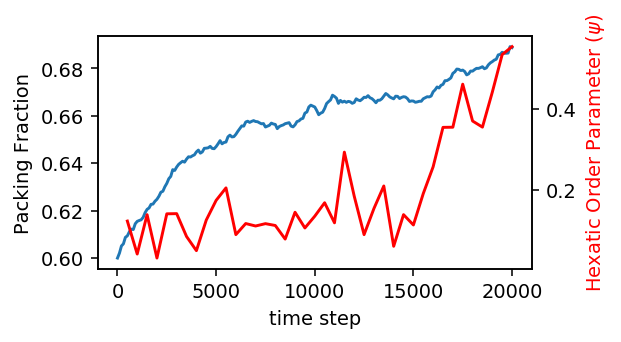

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import gsd.hoomd
%matplotlib inline

with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
    N = traj[-1].particles.N
# alternately, use a custom log operation to log phi directly

log = np.genfromtxt(fname=JOB.fn('log.dat'), names=True)
psi = np.load(JOB.fn('order.npz'))

fig, ax = plt.subplots(figsize=(4, 2.2), dpi=140)
ax2 = ax.twinx()

ax.plot(log['timestep'], N * JOB.doc.poly_area / log['volume'])
ax.set_xlabel('time step')
ax.set_ylabel('Packing Fraction')

ax2.plot(psi['steps'], np.absolute(psi['psi'].mean(axis=1)), color='red')
ax2.set_ylabel('Hexatic Order Parameter ($\psi$)', color='red')

plt.show()

Fluids and solids will show different behavior:
* **Fluid:** Low pressure fluids will exhibit very little hexatic order, the equilibrium $\psi$ will be very small.
* **Solid:** In ordered solids, $\psi$ will be large, approximately 0.5 and greater.

# Hexatic order parameter

We can also visualize the system directly, with each particle colored by the value of the local hexatic order parameter.
Note that instead of using the stored values, we are now using [`freud`](https://freud.readthedocs.io/en/stable/order.html#freud.order.HexOrderParameter) to calculate the order parameter on the fly each time we visualize a new frame.

In [5]:
import freud
from draw_utils import quat2ang, draw_config, draw_pmft, draw_voronoi

with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
    num_frames = len(traj)-1 

In [6]:
@interact(frame=(1, num_frames))
def frame_demo(frame=num_frames):
    fix, ax = plt.subplots(1, 1, figsize=(8, 8))
    with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
        frame = traj[frame]
        
        box = freud.box.Box.from_box(frame.configuration.box[:2].tolist())
        hop = freud.order.HexOrderParameter(rmax=1.2, k=6)
        hop.compute(box, frame.particles.position)
        
        draw_config(fig, ax, box, frame.particles.position, quat2ang(frame.particles.orientation), hop.psi, JOB.sp.n)

Fluids and solids will show different behavior:
* **Fluid:** Fluids have very little correlation in hexatic order. Particles will show the full range of the color wheel:
* **Solid:** In ordered solids, all the local environments are ordered. Particles will most all be the same color (except in a few local regions near defects).

## RDF

Another way we can see this more clearly is using the [radial distribution function (RDF)](https://en.wikipedia.org/wiki/Radial_distribution_function), which measures the system density as a function of distance from a particle.
The RDF is measured by calculating the average number of particles at a given distance from each particle and then averaging that measure over all particles.
In a perfect crystal, the RDF should be just a set of [delta functions](https://en.wikipedia.org/wiki/Delta_function) since all particles are located at precise fixed distances from one another.
In systems of particles like the ones we are simulating, we instead expect to see smoother sets of peaks.

Below, we calculate the RDF by binning all particles using `freud` (see [the documentation](https://freud.readthedocs.io/en/stable/density.html#freud.density.RDF) for more information).

In [7]:
@interact(frame=(1, num_frames))
def rdf_demo(frame=num_frames):
    with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
        frame = traj[frame]
            
        box = freud.box.Box.from_box(frame.configuration.box[:2].tolist())
        rdf = freud.density.RDF(np.sqrt(box.Lx**2 + box.Ly**2)/5, box.Lx/1000)
        rdf.compute(box, frame.particles.position)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.plot(rdf.R, rdf.RDF)

Both fluids and solids will show a few strong peaks as there are short range correlations. Where they differ:
* **Fluid:** g(r) will tend toward 1.0 at moderate and large values of r.
* **Solid:** g(r) will show oscillations out to large values of r. Solids take some time to develop, so early frames may show fluid-like behavior while later frames develop longer range correlations.

However, as it is a function of distance alone, the RDF is clearly a limited way of characterizing our system, which we know should exhibit some ordering that depends on the angle between particles.

## PMFT

To get a more informative picture, we can look at the potential of mean force and torque (PMFT).
The PMFT is a generalization of the classical [potential of mean force](https://en.wikipedia.org/wiki/Potential_of_mean_force) (PMF), which measures the average potential energy surface about each particle in the system as a function of distance.
The PMF can be calculated directly as $w(r) = -\beta \log(g(r))$ (where $g(r)$ is the radial distribution function).

The PMFT takes this one step further, looking at the potential energy surface as a function of both distance and angle.
As a result, the PMFT can capture the differences in a potential energy surface induced by, for instance, the shape of a particle.
In practice, the PMFT is calculated by [binning space and counting particles](https://freud.readthedocs.io/en/stable/pmft.html#freud.pmft.PMFTXY2D).
We plot the results below.

In [8]:
@interact(frame=(1, num_frames))
def pmft_demo(frame=num_frames):
    with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
        frame = traj[frame]
            
        box = freud.box.Box.from_box(frame.configuration.box[:2].tolist())
        pmft = freud.pmft.PMFTXY2D(4, 4, 300, 300)
        pmft.compute(box, frame.particles.position, quat2ang(frame.particles.orientation))

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    draw_pmft(fig, ax, pmft, JOB.sp.n)

Looking at early frames of our simulation, we see that the PMFT looks almost circularly uniform.
In fact, in this case the PMFT shows the same information as the RDF.
There is a low energy ring immediately surrounding the central particle, and past that we see a mostly uniform potential energy surface at all distances.
The PMFT doesn't tell us much about the fluid-solid transition, but does help explain how the effective interactions between polygons changes.

* **Low vertex polygons**: In later frames, however, we start to see more features.
In particular, the PMFT shows smaller energy wells near the edges of the polygon, indicating polygons like to sit edge to edge. 
* **High vertex polygons**: In later frames, you should still see circular rings. These polygons are close enough to circles that they don't feel there edges strongly.

Note: The system sizes in this tutorial are very small and the PMFTs are only obtained from a single frame. For much cleaner PMFT data, one should use larger system sizes and average over many frames. See the paper [Shape and Symmetry Determine Two-Dimensional Melting Transitions of Hard Regular Polygons](http://dx.doi.org/10.1103/PhysRevX.7.021001) for well-sampled PMFTs of polygons.

This is additional information not present in the orientationally averaged RDF.

## Voronoi diagram

We saw defects in the system with the hexatic order parameter earlier.
Another way to count defects is to look at the [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) of the system.
Using the particle positions as reference points, the Voronoi diagram partitions space and finds every point is associated with the closest reference point.
In a **perfectly ordered system**, we would expect the Voronoi diagram to divide space into perfect hexagons.
Anywhere there are defects in the system, however, we would expect the Voronoi diagram to show pentagons and heptagons (and occasionally larger polygons).
To demonstrate this, we plot the Voronoi diagrams below, with each Voronoi polygon colored by the number of sides.

In [9]:
@interact(frame=(1, num_frames))
def voronoi_demo(frame=num_frames):
    with gsd.hoomd.open(JOB.fn('trajectory.gsd')) as traj:
        frame = traj[frame]
            
        box = freud.box.Box.from_box(frame.configuration.box[:2].tolist())
        voronoi = freud.voronoi.Voronoi(box, np.sqrt(box.Lx**2 + box.Ly**2)/5)
        voronoi.compute(frame.particles.position, box)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    draw_voronoi(fig, ax, box, voronoi.polytopes)

As we see, early on in the simulation that there are many 5- and 7-gons, as the system is still equilibrating.
When equilibrated, you should see:

* **Fluid**: Mostly hexagons, but a high concentration of 5- and 7-gons connected to each other.
* **Solid**: Mostly hexagons, with a few 5- and 7-gons connected to each other.

Solids in 2D only have "quasi" long range order due to an appreciable concentration of defects at equilibrium. Compare the Voronoi diagram to the same frame above with the hexatic order parameter coloring and the defects should be visible in the same locations.

## Identifying the fluid-solid transition

Finally, we return to our original problem: finding the pressure at which the system undergoes a phase transition.
We plot the average value of the hexatic order parameter (in the final $N$ frames of our simulation) as a function of pressure, and we look for a pressure at which we see a sudden jump in the order parameter.

We will store the identified transition pressures in a dict as part of the *project document*.
The *project document*, like the *job document* is a key-value storage, but central to the project.
Ideal for data that does not directly belong to a specific job.

In [10]:
betaP_transitions = project.doc.setdefault('betaP_transition', dict())

Next, we define a function that calculates the average hexatic order parameter for a set of jobs.

In [11]:
def compute_average_hexatic_order_parameter(jobs, num_frames):
    hops = []
    for job in jobs:
        if job.isfile('trajectory.gsd'):
            with gsd.hoomd.open(job.fn('trajectory.gsd')) as traj:
                for frame in traj[-num_frames:]:
                    box = freud.box.Box.from_box(frame.configuration.box[:2].tolist())
                    hop = freud.order.HexOrderParameter(rmax=1.2, k=6)
                    try:
                        hop.compute(box, frame.particles.position)
                        hops.append(np.absolute(np.mean(hop.psi)))
                    except RuntimeError as error:
                        print("{}: {}".format(job, error), file=sys.stderr)
        else:
            print("Missing data:", job, file=sys.stderr)
    return np.mean(hops) if hops else np.nan

Then we implement an **interactive** plot that allows us to 

 1. display the average hexactic order parameter at the simulated pressures,
 2. initialize new jobs at selected pressures, and
 3. save the selected pressure as the transition pressure.
 

 * To initialize new jobs, move the slider to the desired pressure and click the `[Init new jobs]` button. You can then run the new jobs by either executing the `./project.py run --parallel` command on the command line or by clicking on the `[Run remaining jobs]` button.
 * To store a transition pressure, move the slider to the desired pressure and click on the `[Store transition pressure]` button.

**The following cell contains a lot of code that is concerned with the logic of setting up the interactive plot.
It is not crucial to follow all steps below!**

In [12]:
from matplotlib import pyplot as plt
from ipywidgets import widgets, interactive
from IPython.display import display, clear_output, Markdown
from init import init_jobs
from multiprocessing import Process

# import hoomd
# hoomd.option.set_notice_level(0)
# hoomd.util.quiet_status()

# We set up one widget that allows us to select the number of vertices (n)
# and one widget that controls the pressure slider.
n_widget = widgets.Dropdown(options=list(project.detect_schema()['n'][int]))
betaPs = project.detect_schema()['betaP'][float]
betaP_widget = widgets.FloatSlider(value=min(betaPs), min=min(betaPs), max=max(betaPs), step=0.1)

# Since we might have simulated different ranges of pressure for each number
# of vertices, we update the pressure slider dynamically.
def set_betaP_range(arg, num_frames=5):
    betaPs = {job.sp.betaP for job in project.find_jobs({'n': arg['new']})}
    betaP_widget.min, betaP_widget.max = min(betaPs), max(betaPs)
    betaP_widget.value = min(betaPs)
n_widget.observe(set_betaP_range, 'value')


def plot_hexactic_order_parameter_vs_pressure(n=0, betaP_select=None, num_frames=5):
    """Plot the hexactic order parameter versus the pressure.
    
    This is an interactive plot that allows users to initialize new simulation jobs
    for the selected pressure or set the selected pressure as the transition pressure.
    """
    
    # Compute the average hexatic order parameter (hop) as a fcuntion of the pressure.
    # This function utilizes job selection with find_jobs() and a grouping operation
    # groupby() in combination with a dict-comprehension.
    avg_hop = {betaP: compute_average_hexatic_order_parameter(group, num_frames)
               for betaP, group in project.find_jobs(dict(n=n)).groupby('betaP')}
    
    # Plot the order parameter versus pressure.
    fig, ax = plt.subplots()
    ax.set_title('$n={}$'.format(n))
    ax.scatter(avg_hop.keys(), avg_hop.values())
    ax.set_xlabel(r'Pressure $\beta P$')
    ax.set_ylabel('Average hexatic order parameter')
    
    # Identified any missing values and display a blue dotted line where no data is available.
    x_nans = [x for x in avg_hop if np.isnan(avg_hop[x])]
    for x in x_nans:
        ax.axvline(x=x, c='blue', ls=':', alpha=0.25)
    if x_nans:
        display(Markdown("WARNING: Some data is missing. Make sure to execute all jobs for "
                "example by clicking on the `[Run remaining jobs]` button or "
                "by executing `./project.py run --parallel` on the command line."))
        

    # Get the transition pressure for the given n.
    # Note: Keys in JSON are *always* strings, even if they represent numbers.
    betaP_stored = betaP_transitions.get(str(n))
#     betaP_stored = project.doc.betaP_transition.get(str(n))

    if betaP_stored is None:
        # No transition pressure stored yet.
        ax.text(0.5, 0.5, 'No transition pressure stored yet.', transform=ax.transAxes, horizontalalignment='center')
    else:
        # Plot the (stored) transition pressure as a red solid line.
        ax.axvline(x=betaP_stored, c='red')
        ax.text(betaP_stored - 0.2, 0.2, 'stored', rotation=90, transform=ax.get_xaxis_transform())    
    
    if betaP_stored is None or betaP_stored != betaP_select:
        # Plot the selected pressure as a dashed red line.
        ax.axvline(x=betaP_select, color='red', ls='--', alpha=0.5)
        ax.text(betaP_select - 0.2, 0.2, 'selected', rotation=90, transform=ax.get_xaxis_transform())

    
    plt.show()

    
# Convert the plotting function into an interactive function.
f = interactive(plot_hexactic_order_parameter_vs_pressure, n=n_widget, betaP_select=betaP_widget, num_frames=(1, 10))

#
# Setup the three buttons:
#

def save_transition_pressure(button):
    "Store the selected pressure in the project document."
    n, betaP = n_widget.value, betaP_widget.value
    project.doc.setdefault('betaP_transition', dict())[str(n)] = betaP
    display("Transition pressure for n={} set to {}.".format(n, betaP))
    clear_output(wait=True)
    f.update()
button_save = widgets.Button(description='Store transition pressure')
button_save.on_click(save_transition_pressure)


def init_new_job(button):
    "Initialize new jobs for the selected pressure."
    init_jobs(project, n=n_widget.value, betaP=betaP_widget.value)
    display("Initialized new jobs for pressure {}.".format(betaP_widget.value))
    clear_output(wait=True)
    f.update()
button_init = widgets.Button(description='Init new jobs')
button_init.on_click(init_new_job)

button_run_remaining = widgets.Button(description="Run remaining jobs")
def _run_remaining_process():
    "Call the project.run() function and enable the button after completion."
    project.run(np=True, progress=True)
    button_run_remaining.disabled = False
    f.update()

def run_remaining_jobs(button):
    process = Process(target=_run_remaining_process)
    display("Running remaining jobs...")
    button_run_remaining.disabled = True
    process.start()
button_run_remaining.on_click(run_remaining_jobs)


# Display the interactive plot and the three buttons directly below it.
display(f, widgets.HBox((button_init, button_run_remaining, button_save)))

After we have identified  transition pressures for the different shapes, we can plot them all together in one diagram.

You might want to initialize more simulations with the `./init.py` script for other vertices (*e.g.* `./init.py 6`).

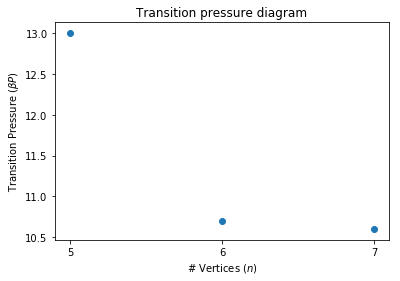

In [13]:
from IPython.display import HTML


ns = list(sorted(project.doc.betaP_transition))
betaPs = [betaP_transitions[n] for n in ns]

if len(ns):
    fig, ax = plt.subplots()
    ax.scatter(ns, betaPs)
    ax.set_xlabel('# Vertices ($n$)')
    ax.set_ylabel(r"Transition Pressure ($\beta P$)")
    ax.set_title("Transition pressure diagram")
    plt.show()
else:
    display(HTML('<font color="red">No transition pressures stored yet.</font>'))